## Objective of project

#### Key Points
Key points to keep in mind when data wrangling for this project:

1. You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
2. Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least **8 quality issues** and at least **2 tidiness issues** in this dataset.
3. Cleaning includes merging individual pieces of data according to the rules of tidy data.
4. The fact that the rating numerators are greater than the denominators does not need to be cleaned. This unique rating system is a big part of the popularity of WeRateDogs.
5. You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.

#### Storing, Analyzing, and Visualizing Data for this Project
Store the clean DataFrame(s) in a CSV file with the main one named **twitter_archive_master.csv**. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).

Analyze and visualize your wrangled data in your wrangle_act.ipynb Jupyter Notebook. **At least three (3) insights and one (1) visualization must be produced.**

#### Reporting for this Project
1. Create a **300-600** word written report called *wrangle_report.pdf or wrangle_report.html* that briefly describes your wrangling efforts. This is to be framed as an internal document.

2. Create a **250-word-minimum written report** called *act_report.pdf or act_report.html* that communicates the insights and displays the visualization(s) produced from your wrangled data. This is to be framed as an external document, like a blog post or magazine article, for example.

# Import libraries 


In [1]:
import tweepy
import numpy as np
import pandas as pd
import json
import os
import requests
import time
import re

# Gathering data

### 1. Opening 'twitter-archive_enhanced.csv' file 

In [2]:
twitter_arch = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
twitter_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. Gathering data from URL provided by Udacity to get the 'image-prediction.tsv' file

In [4]:
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

file = open("image-predictions.tsv", "wb").write(response.content)

In [5]:
df_image_predictions = pd.read_csv('image-predictions.tsv',sep='\t')

In [6]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. API request to get Twitter data

In [7]:
consumer_key = 'hidden'
consumer_secret = 'hidden'
access_token = 'hidden'
access_secret = 'hidden'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [8]:
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [9]:
tweet_ids = twitter_arch.tweet_id.values

In [10]:
list_tweet_error = []

list_tweet = []
            
start = time.time() 


# Save each tweet's returned JSON as a new line in a .txt file
for tweet_id in tweet_ids:
    try:
        tweet = api.get_status(tweet_id, tweet_mode= 'extended')._json 
        
        favorite_count = tweet['favorite_count'] # number of favorites for the tweet
        retweet_count = tweet['retweet_count'] # number of retweets
     
        
        list_tweet.append({'tweet_id': int(tweet_id),
                        'favorite_count': int(favorite_count),
                        'retweet_count': int(retweet_count)})
    except Exception as e:
        print(str(tweet_id)+ ":" + str(e))
        list_tweet_error.append(tweet_id)
        
# end time for excution
end = time.time()

#printing time for execution
print("Time required for execution", end - start)

Rate limit reached. Sleeping for: 146
888202515573088257:[{'code': 144, 'message': 'No status found with that ID.'}]
873697596434513921:[{'code': 144, 'message': 'No status found with that ID.'}]
872668790621863937:[{'code': 144, 'message': 'No status found with that ID.'}]
872261713294495745:[{'code': 144, 'message': 'No status found with that ID.'}]
869988702071779329:[{'code': 144, 'message': 'No status found with that ID.'}]
866816280283807744:[{'code': 144, 'message': 'No status found with that ID.'}]
861769973181624320:[{'code': 144, 'message': 'No status found with that ID.'}]
856602993587888130:[{'code': 144, 'message': 'No status found with that ID.'}]
851953902622658560:[{'code': 144, 'message': 'No status found with that ID.'}]
845459076796616705:[{'code': 144, 'message': 'No status found with that ID.'}]
844704788403113984:[{'code': 144, 'message': 'No status found with that ID.'}]
842892208864923648:[{'code': 144, 'message': 'No status found with that ID.'}]
83736628487457

In [11]:
print('Total number of available tweets is',len(list_tweet))
print('Total number of error tweets is',len(list_tweet_error))

Total number of available tweets is 2331
Total number of error tweets is 25


In [74]:
df_twitter_api_raw = pd.DataFrame(list_tweet,columns=['tweet_id','favorite_count','retweet_count'])

In [78]:
df_twitter_api_raw.to_csv('twitter_api.csv', sep=',', index = False, encoding='utf-8')

In [7]:
df_twitter_api = pd.read_csv('twitter_api.csv')

In [8]:
df_twitter_api.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36556,7785
1,892177421306343426,31488,5765
2,891815181378084864,23738,3816
3,891689557279858688,39881,7955
4,891327558926688256,38084,8589


### Assessing data 

#### 1. twitter_archive_enhance file 

In [9]:
twitter_arch.shape

(2356, 17)

In [10]:
twitter_arch.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
twitter_arch.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
383,827199976799354881,NaN,NaN,2017-02-02 17:00:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Charlie. He wins every game of chess h...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/827199976...,13,10,Charlie,None,None,None,None
1964,673350198937153538,NaN,NaN,2015-12-06 03:56:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She's a Genghis Flopped Canuck....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673350198...,9,10,Bella,None,None,None,None
667,790337589677002753,NaN,NaN,2016-10-23 23:42:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Maggie. She can hear your cells divide. 1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/790337589...,12,10,Maggie,None,None,None,None
472,816450570814898180,NaN,NaN,2017-01-04 01:05:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Moose. He doesn't want his friend to go b...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/816450570...,13,10,Moose,None,None,None,None
1745,679148763231985668,NaN,NaN,2015-12-22 03:57:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I know everyone's excited for Christmas but th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/679148763...,8,10,None,None,None,None,None


In [12]:
twitter_arch.tail(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None
2355,666020888022790149,NaN,NaN,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a Japanese Irish Setter. Lost eye...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666020888...,8,10,None,None,None,None,None


In [13]:
twitter_arch.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
twitter_arch.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

>**I will change the datatype of timestamp to datetime, and tweet_id to string.**

In [15]:
twitter_arch.tweet_id.duplicated().sum()

0

In [16]:
twitter_arch.query('in_reply_to_status_id != "NAN"').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None


In [59]:
# I want to understand whether all these non-null values add any additional values for analysis
twitter_arch.in_reply_to_status_id.loc[30]

8.8626635707512832e+17

In [17]:
twitter_arch.query('retweeted_status_id != "NAN"').head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None


In [61]:
twitter_arch.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
Cooper       11
Lola         10
Penny        10
Tucker       10
Winston       9
Bo            9
the           8
Sadie         8
an            7
Buddy         7
Toby          7
Daisy         7
Bailey        7
Jack          6
Koda          6
Oscar         6
Milo          6
Scout         6
Stanley       6
Bella         6
Dave          6
Rusty         6
Leo           6
Jax           6
very          5
           ... 
Beya          1
Billy         1
Traviss       1
Dotsy         1
Cermet        1
Keet          1
Kawhi         1
Tebow         1
Chaz          1
Jo            1
Opie          1
Kloey         1
Trigger       1
Dietrich      1
Bones         1
Lilli         1
Ferg          1
Major         1
Clybe         1
Skittle       1
Sky           1
Julius        1
Link          1
Arya          1
Jareld        1
Tater         1
Brockly       1
Wishes        1
Peanut        1
Arlen         1
Name: name, Length: 957,

In [112]:
badnames = twitter_arch[twitter_arch.name.str.islower()]
badnames['name'].unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [113]:
twitter_arch[(twitter_arch.name == 'such')][['tweet_id','text','name']]

,tweet_id,text,name
22,887517139158093824,I've yet to rate a Venezuelan Hover Wiener. Th...,such


In [114]:
twitter_arch.text.loc[22]

"I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba"

In [115]:
twitter_arch[(twitter_arch.name == 'a')][['tweet_id','text','name']].sample(5)

,tweet_id,text,name
2352,666044226329800704,This is a purebred Piers Morgan. Loves to Netf...,a
1049,743222593470234624,This is a very rare Great Alaskan Bush Pupper....,a
2347,666057090499244032,My oh my. This is a rare blond Canadian terrie...,a
1737,679530280114372609,Guys this really needs to stop. We've been ove...,a
1994,672604026190569472,This is a baby Rand Paul. Curls for days. 11/1...,a


In [116]:
twitter_arch.text.loc[1878]

'This is a fluffy albino Bacardi Columbia mix. Excellent at the tweets. 11/10 would hug gently https://t.co/diboDRUuEI'

In [117]:
twitter_arch.text.loc[1017]

'This is a carrot. We only rate dogs. Please only send in dogs. You all really should know this by now ...11/10 https://t.co/9e48aPrBm2'

In [248]:
twitter_arch.text.loc[2034]

'This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7'

In [119]:
withnames = twitter_arch[twitter_arch.name.str.islower()][(twitter_arch['text'].str.contains('named'))][['tweet_id','text','name']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [121]:
withnames.text

1853    This is a Sizzlin Menorah spaniel from Brookly...
1955    This is a Lofted Aphrodisiac Terrier named Kip...
2034    This is a Tuscaloosa Alcatraz named Jacob (Yac...
2066    This is a Helvetica Listerine named Rufus. Thi...
2116    This is a Deciduous Trimester mix named Spork....
2125    This is a Rich Mahogany Seltzer named Cherokee...
2128    This is a Speckled Cauliflower Yosemite named ...
2146    This is a spotted Lipitor Rumpelstiltskin name...
2161    This is a Coriander Baton Rouge named Alfredo....
2191    This is a Slovakian Helter Skelter Feta named ...
2204    This is an Irish Rigatoni terrier named Berta....
2218    This is a Birmingham Quagmire named Chuk. Love...
2235    This is a Trans Siberian Kellogg named Alfonso...
2249    This is a Shotokon Macadamia mix named Cheryl....
2255    This is a rare Hungarian Pinot named Jessiga. ...
2264    This is a southwest Coriander named Klint. Hat...
2273    This is a northern Wahoo named Kohl. He runs t...
2304    This i

>**It is weird that articles (a/an/the) have been used for names. What I found was that all the names that start with lowercase are indeed errors as a result of extraction of wrong data. I was able to recover some of the names of the dog. I would rename the rest of them to None for those that had no mentions of names in the text column.**


In [44]:
twitter_arch.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

>**I want to get rid of all the html text and condense to only 4 source: "Twitter for iPhone", "Vine - Make a Scene", "Twitter Web Client", and "TweetDeck".**

In [63]:
print(twitter_arch.doggo.value_counts())
print(twitter_arch.floofer.value_counts())
print(twitter_arch.pupper.value_counts())
print(twitter_arch.puppo.value_counts())


None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


>**I want to flatten these 4 columns using MELT function and put the data under a new category called "stage_of_life".**

#### 2. image_predictions file 


In [64]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [65]:
df_image_predictions.shape

(2075, 12)

In [66]:
df_image_predictions.tail(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [67]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [68]:
print(df_image_predictions.p1_dog.value_counts())
print(df_image_predictions.p2_dog.value_counts())
print(df_image_predictions.p3_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64
True     1553
False     522
Name: p2_dog, dtype: int64
True     1499
False     576
Name: p3_dog, dtype: int64


In [69]:
df_image_predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


>**I noticed that the breeds of dogs can be in lowercase or uppercase. I decided to make everything in lowercase.** 

>**I also find that the names of p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog unintuitive. I will rename them from p1/2/3,p1/2/3_conf,p1/2/3_dog to breed_pred_1, breed_pred_1_conf, breed_pred_1_outcome,breed_pred_2, breed_pred_2_conf, breed_pred_2_outcome,breed_prediction_3, breed_pred_3_conf, breed_pred_3_outcome.**

In [70]:
df_image_predictions.shape

(2075, 12)

In [71]:
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


>**I will change the date type of tweet_id to object**

In [72]:
print(df_image_predictions.p1_dog.value_counts())
print()
print(df_image_predictions.p2_dog.value_counts())
print()
print(df_image_predictions.p3_dog.value_counts())

True     1532
False     543
Name: p1_dog, dtype: int64

True     1553
False     522
Name: p2_dog, dtype: int64

True     1499
False     576
Name: p3_dog, dtype: int64


In [73]:
df_image_predictions.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [74]:
df_image_predictions.tweet_id.duplicated().sum()

0

In [45]:
df_image_predictions[df_image_predictions.p1_dog == False].head(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
17,666104133288665088,https://pbs.twimg.com/media/CT56LSZWoAAlJj2.jpg,1,hen,0.965932,False,cock,0.033919,False,partridge,0.000052,False
18,666268910803644416,https://pbs.twimg.com/media/CT8QCd1WEAADXws.jpg,1,desktop_computer,0.086502,False,desk,0.085547,False,bookcase,0.079480,False
21,666293911632134144,https://pbs.twimg.com/media/CT8mx7KW4AEQu8N.jpg,1,three-toed_sloth,0.914671,False,otter,0.015250,False,great_grey_owl,0.013207,False


In [76]:
df_image_predictions.p1.value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
malamute                      30
cocker_spaniel                30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
German_shepherd               20
Staffordshire_bullterrier     20
Siberian_husky                20
web_site                      19
Cardigan                      19
beagle                        18
Maltese_dog                   18
Eskimo_dog                    18
Shetland_sheepdog             18
teddy                         18
Rottweiler                    17
Shih-Tzu                      17
Lakeland_terrier              17
kuvasz                        16
Italian_greyhound             16
          

In [46]:
df_image_predictions[df_image_predictions.p2_dog == False].sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1503,784826020293709826,https://pbs.twimg.com/media/CuRDF-XWcAIZSer.jpg,1,chow,0.090341,True,binoculars,0.083499,False,Irish_setter,0.077456,True
1370,762035686371364864,https://pbs.twimg.com/ext_tw_video_thumb/76203...,1,home_theater,0.063152,False,cash_machine,0.046692,False,theater_curtain,0.046277,False
870,697881462549430272,https://pbs.twimg.com/media/Ca9feqDUAAA_z7T.jpg,1,washbasin,0.176423,False,paper_towel,0.167462,False,toilet_tissue,0.098029,False
1549,792913359805018113,https://pbs.twimg.com/media/CwD-eCLWIAA6v0B.jpg,4,web_site,0.226716,False,lighter,0.081941,False,switch,0.039009,False
1942,861288531465048066,https://pbs.twimg.com/ext_tw_video_thumb/86128...,1,syringe,0.144712,False,oxygen_mask,0.106684,False,Bouvier_des_Flandres,0.082610,True


In [47]:
df_image_predictions[df_image_predictions.p3_dog == False].sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1781,828708714936930305,https://pbs.twimg.com/media/C4AqLSgVYAEg8nt.jpg,1,hippopotamus,0.942911,False,Mexican_hairless,0.008388,True,ice_lolly,0.006206,False
1284,750506206503038976,https://pbs.twimg.com/media/CmpVaOZWIAAp3z6.jpg,1,American_black_bear,0.219166,False,lesser_panda,0.214715,False,titi,0.091685,False
1844,838916489579200512,https://pbs.twimg.com/media/C6RkiQZUsAAM4R4.jpg,2,web_site,0.993651,False,monitor,0.001406,False,envelope,0.001093,False
1902,851861385021730816,https://pbs.twimg.com/media/C8W6sY_W0AEmttW.jpg,1,pencil_box,0.662183,False,purse,0.066505,False,pillow,0.044725,False
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False


>**Looking at the breeds of dogs in column p1/p2/03, it is obvious that a lot of names are wrong as they are some random objects. It appears that when p1/p2/p3 is showing some random objects, the p1_dog/p2_dog/p3_dog column will show "False" as the outcome. I decided not to clean up this part but I will use this information for furth anaylsis**

#### 3. Twitter API data

In [79]:
df_twitter_api.sample(5)

,tweet_id,favorite_count,retweet_count
1325,704134088924532736,1514,464
1085,733828123016450049,3590,785
1880,674606911342424069,921,95
1296,706346369204748288,3475,934
1670,681281657291280384,3250,1102


In [80]:
df_twitter_api.shape

(2331, 3)

In [81]:
df_twitter_api.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7638.812956,2734.865723
std,6.823170e+16,11853.439466,4624.893707
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1336.000000,553.500000
50%,7.182469e+17,3326.000000,1286.000000
75%,7.986692e+17,9375.000000,3183.500000
max,8.924206e+17,158004.000000,78701.000000


In [82]:
df_twitter_api.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null int64
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(3)
memory usage: 54.7 KB


>**The data looks clean. But there some tweets do not have any favorite_count. They can be outliers so further investigation is required.**
<br>
>**I will also change the data type of tweet_id to object**

In [83]:
df_twitter_api.query('favorite_count == "0"').shape[0]

163

In [84]:
df_twitter_api.query('favorite_count == "0"').sample(5)

,tweet_id,favorite_count,retweet_count
559,800855607700029440,0,1670
404,822163064745328640,0,4912
240,845098359547420673,0,7643
446,817502432452313088,0,3489
177,856330835276025856,0,648


In [85]:
twitter_arch.query('tweet_id == "757597904299253760"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
911,757597904299253760,NaN,NaN,2016-07-25 15:26:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @jon_hill987: @dog_rates There is a cunning...,7.575971e+17,280479778.0,2016-07-25 15:23:28 +0000,https://twitter.com/jon_hill987/status/7575971...,11,10,None,None,None,pupper,None


In [86]:
twitter_arch.text.loc[911]

'RT @jon_hill987: @dog_rates There is a cunningly disguised pupper here mate! 11/10 at least. https://t.co/7boff8zojZ'

In [87]:
twitter_arch.query('tweet_id == "789960241177853952"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
671,789960241177853952,NaN,NaN,2016-10-22 22:42:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Buddy. His father was a...,7.624645e+17,4.196984e+09,2016-08-08 01:44:46 +0000,https://twitter.com/dog_rates/status/762464539...,12,10,Buddy,None,None,None,None


In [88]:
twitter_arch.query('tweet_id == "815745968457060357"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
479,815745968457060357,NaN,NaN,2017-01-02 02:26:09 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Say hello to Levi. He's a Madag...,7.914070e+17,4.196984e+09,2016-10-26 22:31:36 +0000,https://twitter.com/dog_rates/status/791406955...,12,10,Levi,None,None,None,None


In [89]:
twitter_arch.query('tweet_id == "832215726631055365"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
341,832215726631055365,NaN,NaN,2017-02-16 13:11:05 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Moreton. He's the Good ...,7.932865e+17,4.196984e+09,2016-11-01 03:00:09 +0000,https://twitter.com/dog_rates/status/793286476...,13,10,Moreton,None,None,None,None


In [90]:
twitter_arch.query('tweet_id == "832769181346996225"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
332,832769181346996225,NaN,NaN,2017-02-18 01:50:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @EmilieGambril: 12/10 h*cking excited about...,8.327664e+17,487197737.0,2017-02-18 01:39:12 +0000,https://twitter.com/EmilieGambril/status/83276...,12,10,None,None,None,None,None


>**Information looks normal. Seems like all the tweets without favourite counts are all reweets. I decided not to take any actions**

#### Summary of my findings from assessment

#### 1. Twitter archive enhanced file

**Dirty Data**
1. Changing the data type of timestamp from object to datetime, and tweet_id to object. 
2. Truncating the html codes in 'source' column to four categories: 'Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck'. 
3. Renaming column name from 'name' to 'dog_name' to make it more comprehensible.
4. Grouping up the names that start with lowercase to None, except for the ones where names could be recovered from the text column. 
5. The rating_denominator should always be 10. I will update all the cells from whatever they are to 10. 
6. Delete retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp, in_reply_to_status_id,in_reply_to_user_id as this information does not bring additional values to the analysis.


**Messy Data** 
1. Flattening the data in columns "doggo", "puppo","floofer", "pupper" by using pandas MELT function. The data will be regrouped to a new column called "growth_stage". Investigate if each tweet has more than one growth_stage first before rolling out the changes. 


#### 2. Image Predictions File 
**Dirty Data**
1. Renaming column names from  p1/2/3,p1/2/3_conf,p1/2/3_dog to breed_pred_1, breed_pred_1_conf, breed_pred_1_outcome,breed_pred_2, breed_pred_2_conf, breed_pred_2_outcome,breed_prediction_3, breed_pred_3_conf, breed_pred_3_outcome to give these columns more meanings. 
2. Updating all the breeds of dogs in column p1, p2, p3 to lowercase to maintain consistency. 
3. Changing the data type of tweet_id to object

#### 3. Twitter API data
**Dirty Data**
1. Changing the data type of tweet_id to object



### Merging the tables above 
**Messy Data** 
1. After each table has been cleaned up, I will merge all these tables together. 




### Cleaning data 

#### 1. Twitter_archive_enhanced file

In [48]:
## creating a new dataframe for cleaning data so I don' lose the original file.

twitter_arch_cleaned = twitter_arch.copy()

In [49]:
twitter_arch_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

**Define** : Changing the timestamp from object to datetime, changing the tweet_id from int64 to object

**Code**

In [50]:
# Using pandas' to_date function to change data type
twitter_arch_cleaned['timestamp'] = pd.to_datetime(twitter_arch_cleaned.timestamp)
twitter_arch_cleaned['tweet_id'] = twitter_arch_cleaned.tweet_id.astype('object')


**Test**

In [51]:
twitter_arch_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null object
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](

**Define** : Renaming column name from 'name' to 'dog_name' to make it more comprehensible

**Code**

In [53]:
twitter_arch_cleaned = twitter_arch_cleaned.rename(columns={'name': 'dog_name'})

**Test**

In [54]:
twitter_arch_cleaned.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


**Define** : In the dog_name column, filter all the names that start with lowercase and recover the name of the dog from the text column. If they don't have a name, update them to None. 

**Code**

In [201]:
withnames.index

Int64Index([1853, 1955, 2034, 2066, 2116, 2125, 2128, 2146, 2161, 2191, 2204,
            2218, 2235, 2249, 2255, 2264, 2273, 2304, 2311, 2314],
           dtype='int64')

In [202]:
print('1853',withnames['text'].loc[1853])
print('1955',withnames['text'].loc[1955])
print('2034',withnames['text'].loc[2034])
print('2066',withnames['text'].loc[2066])
print('2116',withnames['text'].loc[2116])
print('2125',withnames['text'].loc[2125])
print('2128',withnames['text'].loc[2128])
print('2146',withnames['text'].loc[2146])
print('2161',withnames['text'].loc[2161])
print('2191',withnames['text'].loc[2191])
print('2204',withnames['text'].loc[2204])
print('2218',withnames['text'].loc[2218])
print('2235',withnames['text'].loc[2235])
print('2249',withnames['text'].loc[2249])
print('2255',withnames['text'].loc[2255])
print('2264',withnames['text'].loc[2264])
print('2273',withnames['text'].loc[2273])
print('2304',withnames['text'].loc[2304])
print('2311',withnames['text'].loc[2311])
print('2314',withnames['text'].loc[2314])


1853 This is a Sizzlin Menorah spaniel from Brooklyn named Wylie. Lovable eyes. Chiller as hell. 10/10 and I'm out.. poof https://t.co/7E0AiJXPmI
1955 This is a Lofted Aphrodisiac Terrier named Kip. Big fan of bed n breakfasts. Fits perfectly. 10/10 would pet firmly https://t.co/gKlLpNzIl3
2034 This is a Tuscaloosa Alcatraz named Jacob (Yacōb). Loves to sit in swing. Stellar tongue. 11/10 look at his feet https://t.co/2IslQ8ZSc7
2066 This is a Helvetica Listerine named Rufus. This time Rufus will be ready for the UPS guy. He'll never expect it 9/10 https://t.co/34OhVhMkVr
2116 This is a Deciduous Trimester mix named Spork. Only 1 ear works. No seat belt. Incredibly reckless. 9/10 still cute https://t.co/CtuJoLHiDo
2125 This is a Rich Mahogany Seltzer named Cherokee. Just got destroyed by a snowball. Isn't very happy about it. 9/10 https://t.co/98ZBi6o4dj
2128 This is a Speckled Cauliflower Yosemite named Hemry. He's terrified of intruder dog. Not one bit comfortable. 9/10 https://t.co/

In [214]:
twitter_arch_cleaned['dog_name'][1853] = 'Wylie'
twitter_arch_cleaned['dog_name'][1955] = 'Kip'
twitter_arch_cleaned['dog_name'][2034] = 'Jacob'
twitter_arch_cleaned['dog_name'][2066] = 'Rufus'
twitter_arch_cleaned['dog_name'][2116] = 'Spork'
twitter_arch_cleaned['dog_name'][2125] = 'Cherokee'
twitter_arch_cleaned['dog_name'][2128] = 'Hemry'
twitter_arch_cleaned['dog_name'][2146] = 'Alphred'
twitter_arch_cleaned['dog_name'][2161] = 'Alfredo'
twitter_arch_cleaned['dog_name'][2191] = 'Leroi'
twitter_arch_cleaned['dog_name'][2204] = 'Berta'
twitter_arch_cleaned['dog_name'][2218] = 'Chuk'
twitter_arch_cleaned['dog_name'][2235] = 'Alfonso'
twitter_arch_cleaned['dog_name'][2249] = 'Cheryl'
twitter_arch_cleaned['dog_name'][2255] = 'Jessiga'
twitter_arch_cleaned['dog_name'][2264] = 'Klint'
twitter_arch_cleaned['dog_name'][2273] = 'Kohl'
twitter_arch_cleaned['dog_name'][2304] = 'Pepe'
twitter_arch_cleaned['dog_name'][2311] = 'Octaviath'
twitter_arch_cleaned['dog_name'][2314] = 'Johm'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-p

In [215]:
twitter_arch_cleaned[twitter_arch_cleaned.text.str.contains('named')][['tweet_id','dog_name']]

,tweet_id,dog_name
603,798628517273620480,None
1853,675706639471788032,Wylie
1955,673636718965334016,Kip
2034,671743150407421952,Jacob
2066,671147085991960577,Rufus
2116,670427002554466305,Spork
2125,670361874861563904,Cherokee
2128,670303360680108032,Hemry
2146,669923323644657664,Alphred
2161,669564461267722241,Alfredo


>**Most names have been updated. However, I noticed that I could potentially find the names via the text column for some dogs' name with *None*.**

In [216]:
twitter_arch_cleaned[(twitter_arch_cleaned.dog_name == "None") & (twitter_arch_cleaned['text'].str.contains('named'))][['tweet_id','text','dog_name']]

,tweet_id,text,dog_name
603,798628517273620480,RT @dog_rates: This a Norwegian Pewterschmidt ...,None
2166,669363888236994561,Here we have a Gingivitis Pumpernickel named Z...,None
2227,668268907921326080,Here we have an Azerbaijani Buttermilk named G...,None
2269,667509364010450944,This a Norwegian Pewterschmidt named Tickles. ...,None


>**I need to clean up row 603,2166,2277 and 2269**

In [217]:
print('603',twitter_arch_cleaned['text'].loc[603])
print('2166',twitter_arch_cleaned['text'].loc[2166])
print('2227',twitter_arch_cleaned['text'].loc[2227])
print('2269',twitter_arch_cleaned['text'].loc[2269])

603 RT @dog_rates: This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7
2166 Here we have a Gingivitis Pumpernickel named Zeus. Unmatched tennis ball capacity. 10/10 would highly recommend https://t.co/jPkd7hhX7m
2227 Here we have an Azerbaijani Buttermilk named Guss. He sees a demon baby Hitler behind his owner. 10/10 stays alert https://t.co/aeZykWwiJN
2269 This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7


In [219]:
twitter_arch_cleaned['dog_name'][603] = 'Tickles'
twitter_arch_cleaned['dog_name'][2166] = 'Zeus'
twitter_arch_cleaned['dog_name'][2227] = 'Guss'
twitter_arch_cleaned['dog_name'][2269] = 'Tickles'

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-p

**Test**

In [220]:
twitter_arch_cleaned[(twitter_arch_cleaned.dog_name == "None") & (twitter_arch_cleaned['text'].str.contains('named'))][['tweet_id','text','dog_name']]

,tweet_id,text,dog_name


**Define**: Update the rest of the names that start with lowercase to *None*

**Code**

In [229]:
#Recalling data from a dataframe that I previously created
badnames.name.unique()

array(['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an',
       'very', 'just', 'my', 'his', 'actually', 'getting', 'this',
       'unacceptable', 'all', 'old', 'infuriating', 'the', 'by',
       'officially', 'life', 'light', 'space'], dtype=object)

In [243]:
twitter_arch_cleaned.dog_name.str.islower().sum()

89

>**There are 89 rows with dog_name starting with lowercase need to be updated to None**

In [244]:
allbad = 'such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an','very', 'just', 'my', 'his', 'actually', 'getting', 'this','unacceptable', 'all', 'old', 'infuriating', 'the', 'by','officially', 'life', 'light', 'space'
    

In [245]:
twitter_arch_cleaned.dog_name = twitter_arch_cleaned.dog_name.replace(allbad, 'None')

**Test**

In [246]:
twitter_arch_cleaned[twitter_arch_cleaned_test.dog_name == allbad]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo


In [249]:
twitter_arch_cleaned.dog_name.str.islower().sum()

0

**Define** : Truncating the html codes in 'source' column to four categories: 'Twitter for iPhone', 'Vine - Make a Scene', 'Twitter Web Client', 'TweetDeck'

**Code**

In [250]:
twitter_arch_cleaned.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [251]:
twitter_arch_cleaned.source = twitter_arch_cleaned.source.apply(lambda x: re.findall(r'>(.*)<',x)[0])

**Test**

In [252]:
twitter_arch_cleaned.source.value_counts()

Twitter for iPhone     2221
Vine - Make a Scene      91
Twitter Web Client       33
TweetDeck                11
Name: source, dtype: int64

**Define**: Updating all the rows in column "rating_denominator" to 10 if they are currently not 10. 

**Code**

In [253]:
twitter_arch_cleaned['rating_denominator'] = twitter_arch_cleaned.loc[twitter_arch_cleaned['rating_denominator'] != 10, ['rating_denominator']] = 10


**Test**

In [254]:
twitter_arch_cleaned.rating_denominator.value_counts()

10    2356
Name: rating_denominator, dtype: int64

**Define** : Delete retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp, in_reply_to_status_id,in_reply_to_user_id as this information does not bring additional values to the analysis

**Code**

In [255]:
twitter_arch_cleaned = twitter_arch_cleaned.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp','in_reply_to_status_id','in_reply_to_user_id'],axis=1)

**Test**

In [257]:
twitter_arch_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null object
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
dog_name              2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), int64(2), object(9)
memory usage: 221.0+ KB


**Define** : Flattening the data in columns "doggo", "puppo","floofer", "pupper" by using pandas MELT function. The data will be regrouped to a new column called "growth_stage"

**Code**

In [258]:
#I wanna investigate a bit further first and see if there are any abnomalies before I deploy the melt function on the working dataframe
twitter_arch_cleaned_df = twitter_arch_cleaned.copy()

In [259]:
twitter_arch_cleaned_df = twitter_arch_cleaned_df.melt(id_vars = 'tweet_id',value_vars =['doggo','floofer','pupper','puppo'],var_name='original',value_name = 'growth_stage')

In [260]:
twitter_arch_cleaned_df.head()

,tweet_id,original,growth_stage
0,892420643555336193,doggo,None
1,892177421306343426,doggo,None
2,891815181378084864,doggo,None
3,891689557279858688,doggo,None
4,891327558926688256,doggo,None


In [261]:
twitter_arch_cleaned_df.shape

(9424, 3)

In [262]:
twitter_arch_cleaned_df.query('growth_stage!="None"').duplicated('tweet_id').sum()

14

>**I initially wanted to use the melt function to flatten the data and combine the 4 columns into just one. However, I noticed that 14 samples have more than one growth_stage.**

In [263]:
# I dicided to investigate a bit more to see what contributed to multiple items being select
twitter_arch_cleaned.query('doggo =="doggo"' and 'floofer =="floofer"').sample(10)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo
1091,737445876994609152,2016-05-31 00:49:32,Twitter for iPhone,Just wanted to share this super rare Rainbow F...,https://twitter.com/dog_rates/status/737445876...,13,10,None,None,floofer,None,None
1534,689993469801164801,2016-01-21 02:10:37,Vine - Make a Scene,Here we are witnessing a rare High Stepping Al...,https://vine.co/v/ienexVMZgi5,12,10,None,None,floofer,None,None
774,776218204058357768,2016-09-15 00:36:55,Twitter for iPhone,Atlas rolled around in some chalk and now he's...,https://twitter.com/dog_rates/status/776218204...,13,10,None,None,floofer,None,None
200,854010172552949760,2017-04-17 16:34:26,Twitter for iPhone,"At first I thought this was a shy doggo, but i...",https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
46,883360690899218434,2017-07-07 16:22:55,Twitter for iPhone,Meet Grizzwald. He may be the floofiest floofe...,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,None,None
1022,746542875601690625,2016-06-25 03:17:46,Vine - Make a Scene,Here's a golden floofer helping with the groce...,https://vine.co/v/5uZYwqmuDeT,11,10,None,None,floofer,None,None
1614,685307451701334016,2016-01-08 03:50:03,Twitter for iPhone,Say hello to Petrick. He's an Altostratus Floo...,https://twitter.com/dog_rates/status/685307451...,11,10,Petrick,None,floofer,None,None
984,749317047558017024,2016-07-02 19:01:20,Twitter for iPhone,This is Blu. He's a wild bush Floofer. I wish ...,https://twitter.com/dog_rates/status/749317047...,12,10,Blu,None,floofer,None,None
1110,733822306246479872,2016-05-21 00:50:46,Twitter for iPhone,This is Moose. He's a Polynesian Floofer. Dapp...,https://twitter.com/dog_rates/status/733822306...,10,10,Moose,None,floofer,None,None
582,800388270626521089,2016-11-20 17:20:08,Twitter for iPhone,This is Doc. He takes time out of every day to...,https://twitter.com/dog_rates/status/800388270...,12,10,Doc,None,floofer,None,None


In [264]:
# I found one sample from above
twitter_arch_cleaned.loc[200]

tweet_id                                             854010172552949760
timestamp                                           2017-04-17 16:34:26
source                                               Twitter for iPhone
text                  At first I thought this was a shy doggo, but i...
expanded_urls         https://twitter.com/dog_rates/status/854010172...
rating_numerator                                                     11
rating_denominator                                                   10
dog_name                                                           None
doggo                                                             doggo
floofer                                                         floofer
pupper                                                             None
puppo                                                              None
Name: 200, dtype: object

In [265]:
twitter_arch_cleaned.text.loc[200]

"At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk"

In [266]:
twitter_arch_cleaned_df.growth_stage.value_counts()

None       9030
pupper      257
doggo        97
puppo        30
floofer      10
Name: growth_stage, dtype: int64

>**It seems like maybe I can look up the text content one by one to decide whether I can tidy up the 14 odd samples with multiple growth stages. However, given most data shows *None* anyway, and most dogs are actually not attributed to any growth stage, I decided it is not worth to effort to go through the data one by one. We won't be able to conduct a meaningful anaylsis anyway since most data is missing. I will simply go with the MELT function to sort data.**

In [267]:
twitter_arch_cleaned_df = twitter_arch_cleaned_df.sort_values('growth_stage').drop_duplicates(subset ="tweet_id",keep = 'last',inplace=False)

In [268]:
twitter_arch_cleaned_df.shape

(2356, 3)

In [269]:
twitter_arch_cleaned = pd.merge(twitter_arch_cleaned, twitter_arch_cleaned_df, how='inner', on=['tweet_id'])

In [270]:
twitter_arch_cleaned.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,doggo,floofer,pupper,puppo,original,growth_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,floofer,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,doggo,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,doggo,None
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,doggo,None
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,doggo,None


In [271]:
twitter_arch_cleaned = twitter_arch_cleaned.drop(['doggo','floofer','pupper','puppo','original'],axis=1)

**Test**

In [272]:
twitter_arch_cleaned.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,growth_stage
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None


#### 2. Image Predictions File

In [273]:
# Create a new dataframe for this file
df_image_predictions_cleaned = df_image_predictions.copy()

In [274]:
df_image_predictions_cleaned.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2067,890729181411237888,https://pbs.twimg.com/media/DFyBahAVwAAhUTd.jpg,2,Pomeranian,0.566142,True,Eskimo_dog,0.178406,True,Pembroke,0.076507,True
1035,711743778164514816,https://pbs.twimg.com/media/CeCfMPDW0AAAEUj.jpg,1,Lakeland_terrier,0.459515,True,miniature_poodle,0.219661,True,standard_poodle,0.130189,True
227,670374371102445568,https://pbs.twimg.com/media/CU2l7yvXAAUyYIJ.jpg,1,English_springer,0.974936,True,English_setter,0.011661,True,cocker_spaniel,0.002689,True
1869,844580511645339650,https://pbs.twimg.com/media/C7iNfq1W0AAcbsR.jpg,1,washer,0.903064,False,dishwasher,0.032489,False,printer,0.016456,False
284,671141549288370177,https://pbs.twimg.com/media/CVBfrU9WUAApDeV.jpg,1,guinea_pig,0.387728,False,wood_rabbit,0.171681,False,borzoi,0.075358,True


**Define** : Change data type of tweet_id to object

**Code**

In [294]:
df_image_predictions_cleaned['tweet_id'] = df_image_predictions_cleaned.tweet_id.astype('object')

**Test**

In [296]:
df_image_predictions_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                2075 non-null object
jpg_url                 2075 non-null object
img_num                 2075 non-null int64
breed_pred_1            2075 non-null object
breed_pred_1_conf       2075 non-null float64
breed_pred_1_outcome    2075 non-null bool
breed_pred_2            2075 non-null object
breed_pred_2_conf       2075 non-null float64
breed_pred_2_outcome    2075 non-null bool
breed_pred_3            2075 non-null object
breed_pred_3_conf       2075 non-null float64
breed_pred_3_outcome    2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


**Define** : I will rename them to p1/2/3,p1/2/3_conf,p1/2/3_dog to breed_pred_1, breed_pred_1_conf, breed_pred_1_outcome,breed_pred_2, breed_pred_2_conf, breed_pred_2_outcome,breed_prediction_3, breed_pred_3_conf, breed_pred_3_outcome.

**Code**

In [297]:
df_image_predictions_cleaned = df_image_predictions_cleaned.rename(columns={'p1': 'breed_pred_1','p2':'breed_pred_2','p3':'breed_pred_3','p1_conf':'breed_pred_1_conf',
                                                                           'p2_conf':'breed_pred_2_conf','p3_conf':'breed_pred_3_conf','p1_dog':'breed_pred_1_outcome',
                                                                           'p2_dog':'breed_pred_2_outcome','p3_dog':'breed_pred_3_outcome'})
                                                                                          
                                                                            

**Test**

In [298]:
df_image_predictions_cleaned.head()

,tweet_id,jpg_url,img_num,breed_pred_1,breed_pred_1_conf,breed_pred_1_outcome,breed_pred_2,breed_pred_2_conf,breed_pred_2_outcome,breed_pred_3,breed_pred_3_conf,breed_pred_3_outcome
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


**Define** : Replacing uppercase with lowercase in breed_pred_1, breed_pred_2, breed_pred_3

**Code**

In [299]:
df_image_predictions_cleaned['breed_pred_1'] = df_image_predictions_cleaned['breed_pred_1'].str.lower()

In [300]:
df_image_predictions_cleaned['breed_pred_2'] = df_image_predictions_cleaned['breed_pred_2'].str.lower()

In [301]:
df_image_predictions_cleaned['breed_pred_3'] = df_image_predictions_cleaned['breed_pred_3'].str.lower()

**Test**

In [302]:
df_image_predictions_cleaned.head()

,tweet_id,jpg_url,img_num,breed_pred_1,breed_pred_1_conf,breed_pred_1_outcome,breed_pred_2,breed_pred_2_conf,breed_pred_2_outcome,breed_pred_3,breed_pred_3_conf,breed_pred_3_outcome
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


#### 3. Twitter API data 

This dataset is clean but I still want to create a copy of the original data in case I make mistakes while wrangling with data. 

**Code**

In [303]:
# creating a separate copy so I do not delete information from original data
df_twitter_api_cleaned = df_twitter_api.copy()

In [304]:
df_twitter_api_cleaned.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36556,7785
1,892177421306343426,31488,5765
2,891815181378084864,23738,3816
3,891689557279858688,39881,7955
4,891327558926688256,38084,8589


**Define** : Change data type of tweet_id to object

**Code**

In [321]:
df_twitter_api_cleaned['tweet_id'] = df_twitter_api_cleaned.tweet_id.astype('object')

**Test**

In [322]:
df_twitter_api_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


In [323]:
df_twitter_api_cleaned.shape

(2331, 3)

#### Before I merge data, I decided to download all the cleaned tables as CSVs first. 

In [324]:
twitter_arch_cleaned.to_csv('twitter_arch_cleaned.csv', sep=',', index = False, encoding='utf-8')

In [325]:
df_image_predictions_cleaned.to_csv('df_image_predictions_cleaned.csv', sep=',', index = False, encoding='utf-8')

In [331]:
df_twitter_api_cleaned.to_csv('df_twitter_api_cleaned.csv', sep=',', index = False, encoding='utf-8')

### Merging the three datasets 

In [332]:
temporary = pd.merge(twitter_arch_cleaned,df_image_predictions_cleaned, on=['tweet_id'] ,how='left')

In [333]:
temporary.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,growth_stage,jpg_url,img_num,breed_pred_1,breed_pred_1_conf,breed_pred_1_outcome,breed_pred_2,breed_pred_2_conf,breed_pred_2_outcome,breed_pred_3,breed_pred_3_conf,breed_pred_3_outcome
321,834209720923721728,2017-02-22 01:14:30,Twitter for iPhone,This is Wilson. He's aware that he has somethi...,https://twitter.com/dog_rates/status/834209720...,12,10,Wilson,None,https://pbs.twimg.com/media/C5O1UAaWIAAMBMd.jpg,1.0,golden_retriever,0.754799,True,pekinese,0.197861,True,labrador_retriever,0.008654,True
13,889638837579907072,2017-07-25 00:10:02,Twitter for iPhone,This is Ted. He does his best. Sometimes that'...,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,None,https://pbs.twimg.com/media/DFihzFfXsAYGDPR.jpg,1.0,french_bulldog,0.991650,True,boxer,0.002129,True,staffordshire_bullterrier,0.001498,True
1823,676533798876651520,2015-12-14 22:46:41,Twitter for iPhone,ITSOFLUFFAYYYYY 12/10 https://t.co/bfw13CnuuZ,https://twitter.com/dog_rates/status/676533798...,12,10,None,None,https://pbs.twimg.com/media/CWOH4s9U8AEtkmQ.jpg,1.0,chow,0.265274,True,ice_bear,0.167614,False,fur_coat,0.117506,False


In [334]:
twitter_archive_master_test = pd.merge(temporary,df_twitter_api_cleaned, on=['tweet_id'] ,how='left')

In [335]:
twitter_archive_master_test.head(3)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,growth_stage,jpg_url,...,breed_pred_1_conf,breed_pred_1_outcome,breed_pred_2,breed_pred_2_conf,breed_pred_2_outcome,breed_pred_3,breed_pred_3_conf,breed_pred_3_outcome,favorite_count,retweet_count
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,36556.0,7785.0
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,31488.0,5765.0
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,...,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,23738.0,3816.0


In [336]:
twitter_archive_master_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 22 columns):
tweet_id                2356 non-null object
timestamp               2356 non-null datetime64[ns]
source                  2356 non-null object
text                    2356 non-null object
expanded_urls           2297 non-null object
rating_numerator        2356 non-null int64
rating_denominator      2356 non-null int64
dog_name                2356 non-null object
growth_stage            2356 non-null object
jpg_url                 2075 non-null object
img_num                 2075 non-null float64
breed_pred_1            2075 non-null object
breed_pred_1_conf       2075 non-null float64
breed_pred_1_outcome    2075 non-null object
breed_pred_2            2075 non-null object
breed_pred_2_conf       2075 non-null float64
breed_pred_2_outcome    2075 non-null object
breed_pred_3            2075 non-null object
breed_pred_3_conf       2075 non-null float64
breed_pred_3_outcome    2075

>**I used left join to merge the 3 datasets but decided that this is not the best option for me to conduct analysis as I do not want to have too many nulls in certain columns. I decided I would merge the 3 datasets using inner joins instead.**  

In [337]:
merge = pd.merge(twitter_arch_cleaned,df_twitter_api_cleaned, on=['tweet_id'] ,how='inner')

In [338]:
#I wanna compare how many tweets would be excluded after the merge
twitter_arch_cleaned.shape

(2356, 9)

In [339]:
#Okay, only 25 tweets have been excluded. This is fine. 
merge.shape

(2331, 11)

In [340]:
twitter_archive_master = pd.merge(merge,df_image_predictions_cleaned, on=['tweet_id'] ,how='inner')

In [341]:
twitter_archive_master.shape

(2059, 22)

In [346]:
twitter_archive_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 22 columns):
tweet_id                2059 non-null object
timestamp               2059 non-null datetime64[ns]
source                  2059 non-null object
text                    2059 non-null object
expanded_urls           2059 non-null object
rating_numerator        2059 non-null int64
rating_denominator      2059 non-null int64
dog_name                2059 non-null object
growth_stage            2059 non-null object
favorite_count          2059 non-null int64
retweet_count           2059 non-null int64
jpg_url                 2059 non-null object
img_num                 2059 non-null int64
breed_pred_1            2059 non-null object
breed_pred_1_conf       2059 non-null float64
breed_pred_1_outcome    2059 non-null bool
breed_pred_2            2059 non-null object
breed_pred_2_conf       2059 non-null float64
breed_pred_2_outcome    2059 non-null bool
breed_pred_3            2059 non-null

In [347]:
2331-2059

272

>**After using inner joints, 272 tweets have been excluded. This is alright and I will use this data set to conduct further analysis**

In [348]:
twitter_archive_master.to_csv('twitter_archive_master.csv',sep=',',index = False, encoding='utf-8')

In [3]:
df_master = pd.read_csv('twitter_archive_master.csv')

In [4]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2059 entries, 0 to 2058
Data columns (total 22 columns):
tweet_id                2059 non-null int64
timestamp               2059 non-null object
source                  2059 non-null object
text                    2059 non-null object
expanded_urls           2059 non-null object
rating_numerator        2059 non-null int64
rating_denominator      2059 non-null int64
dog_name                2059 non-null object
growth_stage            2059 non-null object
favorite_count          2059 non-null int64
retweet_count           2059 non-null int64
jpg_url                 2059 non-null object
img_num                 2059 non-null int64
breed_pred_1            2059 non-null object
breed_pred_1_conf       2059 non-null float64
breed_pred_1_outcome    2059 non-null bool
breed_pred_2            2059 non-null object
breed_pred_2_conf       2059 non-null float64
breed_pred_2_outcome    2059 non-null bool
breed_pred_3            2059 non-null object
b

In [372]:
df_master.dog_name.value_counts()

None         649
Oliver        10
Penny         10
Charlie       10
Cooper        10
Tucker        10
Lucy           9
Winston        8
Lola           8
Sadie          8
Bo             8
Daisy          7
Toby           7
Koda           6
Jax            6
Scout          6
Rusty          6
Bailey         6
Stanley        6
Dave           6
Bella          6
Milo           6
Leo            5
Buddy          5
Louis          5
Larry          5
Alfie          5
Oscar          5
Chester        5
Sophie         4
            ... 
Alphred        1
Chevy          1
Jiminus        1
Jordy          1
Ridley         1
Lance          1
Dylan          1
Emanuel        1
Champ          1
Tassy          1
Siba           1
Pancake        1
Ziva           1
Berta          1
Napolean       1
Randall        1
Julius         1
Monster        1
Filup          1
Tayzie         1
Gerbald        1
Mollie         1
Stephanus      1
Dotsy          1
Carll          1
Tom            1
Amélie         1
Sprinkles     

# Data Analysis

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd
%matplotlib inline

#### Question 1: What is the relationship between favourite_count and retweet_count on Twitter?

In [353]:
# I wanna take a quick glance on the data that I want to analyse
df_master[['tweet_id','favorite_count','retweet_count']].head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36556,7785
1,892177421306343426,31488,5765
2,891815181378084864,23738,3816
3,891689557279858688,39881,7955
4,891327558926688256,38084,8589


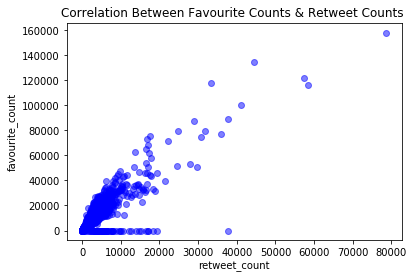

In [354]:
# Create data
x = df_master['retweet_count']
y = df_master['favorite_count']
colors = ('b')


# Plot
plt.scatter(x, y, c=colors, alpha=0.5)
plt.title('Correlation Between Favourite Counts & Retweet Counts ')
plt.xlabel('retweet_count')
plt.ylabel('favourite_count')
plt.show()

In [355]:
x.corr(y)

0.86198770829351778

>#### Insight 1(a)
- The scatter plot above shows that favourite counts and retweet counts are positively correlated. 
- The correlation coefficient between retweet and favourite counts is 0.86, showing a strong positively correlated relationship.
- Some retweets have no favorite_count. 

In [356]:
# Given the insight I gathered on 1a, I want to understand the correlation a bit better
df_master['intercept'] = 1

lm = sm.OLS(df_master['favorite_count'], df_master[['intercept','retweet_count']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         favorite_count   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     5948.
Date:                Tue, 03 Mar 2020   Prob (F-statistic):               0.00
Time:                        13:33:37   Log-Likelihood:                -20892.
No. Observations:                2059   AIC:                         4.179e+04
Df Residuals:                    2057   BIC:                         4.180e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
intercept      2054.6223    156.851     13.099      0.000    1747.019    2362.225
retweet_count     2.2989      0.030     77.121      0.000       2.240       2.357
==============================================================================
Omnibus:                     1212.289   Durbin-Watson:                   1.182
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            88439.298
Skew:                          -1.951   Prob(JB):                         0.00
Kurtosis:                      34.869   Cond. No.                     6.06e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

>#### Insight (1b)
- In the regression model above, retweet_count is the independent variable and the favourite_count is the dependent variable. 
- The regression model above is able to explain 74.3% of the population.
- The P-value of the retweet_count is 0.00, which means that we can reject the null hypothesis of retweet_count having no effect on favourite_count. 
- On average, every one unit of retweet_count leads to an increase of favourite_count by 2.298 unit. 

#### Question 2: What are the sources of the tweets? 

In [357]:
df_master.source.value_counts()

Twitter for iPhone    2019
Twitter Web Client      30
TweetDeck               10
Name: source, dtype: int64

Text(0,0.5,'Count')

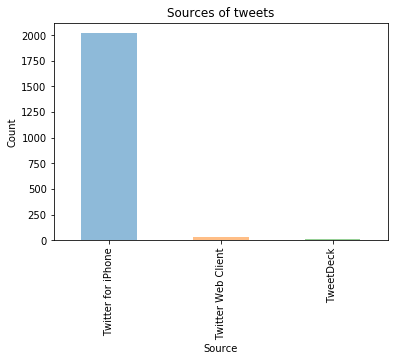

In [358]:
df_master['source'].value_counts().plot(kind='bar',alpha=0.5)
plt.title('Sources of tweets')
plt.xlabel('Source')
plt.ylabel('Count')

>**Insight 2**
- The tweets are predominantly from iPhones.
- There are barely any users from the Twitter website or TweetDeck. 
- However, it seems like the data is lacking information about users who are not using iPhone. There could be a chance that all mobile users have been grouped up as iPhone but this is worth investigating. 

#### Question 3: From the result of the first algorithm to predict the breed of the dog via images, how many images can be predicted with at least 95% confidence and what are they top 5 breeds from the prediction? 

In [359]:
df_master.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,growth_stage,favorite_count,...,breed_pred_1,breed_pred_1_conf,breed_pred_1_outcome,breed_pred_2,breed_pred_2_conf,breed_pred_2_outcome,breed_pred_3,breed_pred_3_conf,breed_pred_3_outcome,intercept
0,892420643555336193,2017-08-01 16:23:56,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,36556,...,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,1
1,892177421306343426,2017-08-01 00:17:27,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,31488,...,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True,1
2,891815181378084864,2017-07-31 00:18:03,Twitter for iPhone,This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,23738,...,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,1
3,891689557279858688,2017-07-30 15:58:51,Twitter for iPhone,This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,39881,...,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False,1
4,891327558926688256,2017-07-29 16:00:24,Twitter for iPhone,This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,38084,...,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True,1


In [360]:
# I want to make sure I am filtering the breed_pred_1_conf with at least 95% confidence, 
#and breed_pred_1_outcome is *True* because I don't want to have results showing non-dog items. 
breed_prediction_1=df_master[df_master.breed_pred_1_conf>=0.95].query('breed_pred_1_outcome')

In [361]:
breed_prediction_1.head()

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,dog_name,growth_stage,favorite_count,...,breed_pred_1,breed_pred_1_conf,breed_pred_1_outcome,breed_pred_2,breed_pred_2_conf,breed_pred_2_outcome,breed_pred_3,breed_pred_3_conf,breed_pred_3_outcome,intercept
10,890006608113172480,2017-07-26 00:31:25,Twitter for iPhone,This is Koda. He is a South Australian decksha...,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,None,29039,...,samoyed,0.957979,True,pomeranian,0.013884,True,chow,0.008167,True,1
12,889665388333682689,2017-07-25 01:55:32,Twitter for iPhone,Here's a puppo that seems to be on the fence a...,https://twitter.com/dog_rates/status/889665388...,13,10,None,puppo,45487,...,pembroke,0.966327,True,cardigan,0.027356,True,basenji,0.004633,True,1
13,889638837579907072,2017-07-25 00:10:02,Twitter for iPhone,This is Ted. He does his best. Sometimes that'...,https://twitter.com/dog_rates/status/889638837...,12,10,Ted,None,25615,...,french_bulldog,0.991650,True,boxer,0.002129,True,staffordshire_bullterrier,0.001498,True,1
14,889531135344209921,2017-07-24 17:02:04,Twitter for iPhone,This is Stuart. He's sporting his favorite fan...,https://twitter.com/dog_rates/status/889531135...,13,10,Stuart,puppo,14312,...,golden_retriever,0.953442,True,labrador_retriever,0.013834,True,redbone,0.007958,True,1
19,888078434458587136,2017-07-20 16:49:33,Twitter for iPhone,This is Gerald. He was just told he didn't get...,https://twitter.com/dog_rates/status/888078434...,12,10,Gerald,None,20606,...,french_bulldog,0.995026,True,pug,0.000932,True,bull_mastiff,0.000903,True,1


In [362]:
num = breed_prediction_1.shape[0]
print('The number of images that can be predicted with at least 95% confidence is',num)

The number of images that can be predicted with at least 95% confidence is 188


In [363]:
df_master.shape

(2059, 23)

In [364]:
pctg_95_conf = breed_prediction_1.shape[0]/df_master.shape[0]
print('The percentage of images that can be predicted with at least 95% confidence is approx.',int(pctg_95_conf*100),'%.')

The percentage of images that can be predicted with at least 95% confidence is approx. 9 %.


In [365]:
df = breed_prediction_1.breed_pred_1.value_counts()

In [366]:
#I want to see the full list of breeds 
df

pug                            21
pembroke                       19
samoyed                        19
golden_retriever               18
pomeranian                     13
chihuahua                       9
french_bulldog                  8
labrador_retriever              7
chow                            7
german_shepherd                 4
shetland_sheepdog               4
bernese_mountain_dog            4
blenheim_spaniel                3
old_english_sheepdog            3
saint_bernard                   3
beagle                          3
pekinese                        3
vizsla                          2
malamute                        2
shih-tzu                        2
cocker_spaniel                  2
basset                          2
english_springer                2
rottweiler                      2
komondor                        2
keeshond                        2
dalmatian                       2
bull_mastiff                    2
boston_bull                     2
siberian_husky

>**Insight 3**
- From the 1st algorithm predicting the breed of dogs, only 188 images could be predicted with at least 95% confidence. 
- When dogs are holding other objects, it seems like all the predictions won't be able to differentiate between objects and dogs from the image as all 3 algorithms have predicted at least 500 non-dog objects.
- Only about 9% of images can be predicted with at least 95% confidence.
- The top 5 breeds from the prediction are pug (21), samoyed (19),pembroke (19), golden_retriever (18) and pomeranian (13).

#### Question 4: Among the 3 prediction algorithms, which one is more reliable?

In [367]:
# I want to know how many images can be predicted with at least 95% confidence using algorithm 2
breed_prediction_2=df_master[df_master.breed_pred_2_conf >= 0.95].query('breed_pred_2_outcome')
breed_prediction_2.shape

(0, 23)

In [368]:
df_master.query('breed_pred_2_outcome').shape[0]

1540

In [8]:
df_master.shape[0]

2059

In [369]:
# I want to know how many images can be predicted with at least 95% confidence using algorithm 3

breed_prediction_3=df_master[df_master.breed_pred_3_conf >= 0.95].query('breed_pred_3_outcome')
breed_prediction_3.shape

(0, 23)

In [370]:
df_master.query('breed_pred_3_outcome').shape[0]

1487

>**Insight 4**
- Among the 3 algorithms, it seems that the first algorithm is more reliable in predicting the breed of dogs via its images as it is able to predict 9% of images with at least 95% confidence. 